## Predictive Analytics
* load and activate the prediction model 

* statistically analyze the predicted sentiment results

* output the individual film sentiment

In [1]:
import json
import time
import os

import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

Using TensorFlow backend.


### load the predictive lstm model

###### init the tokenizer

In [2]:
max_features = 20000
max_sequence_length = 160

data = pd.read_csv('content.csv', index_col= 0)
tokenizer = Tokenizer(num_words=max_features,
                      split=' ',
                      oov_token='<unw>')

tokenizer.fit_on_texts(data['content'].values)

word_index = tokenizer.word_index

###### embedding matrix

In [3]:
# set up the exogenuous paraneter
EMBEDDING_FILE_PATH = '../../glove.840B.300d.txt'
embedding_dim = 300

## Indexing word vectors
embeddings_index = {}
f = open(EMBEDDING_FILE_PATH)
count = 0
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[0])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('load embedding complete')

# derive the num of words
num_words = min(max_features, len(word_index)) + 1
print('num of words: ', num_words)

## Embedding Matrix
embedding_matrix = np.zeros((num_words, embedding_dim))
# for each word in out tokenizer find that word in w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # not exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

2196018it [02:36, 14020.68it/s]


load embedding complete
num of words:  20001


###### model architecture

In [4]:
def create_model(embedding_matrix = embedding_matrix, num_words = num_words,
                 embedding_dim = 300,
                 max_sequence_length = max_sequence_length):
    model = Sequential()

    model.add(Embedding(num_words,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=max_sequence_length,
                        trainable=False))

    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(300, dropout= 0.2, recurrent_dropout= 0.2, return_sequences=True,name='lstm1'),
                                 name='bi_lstm_1'))
    model.add(Bidirectional(LSTM(150, dropout= 0.2, recurrent_dropout= 0.2, name='lstm_2'),
                            name='bi_lstm_2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(units=5, activation='softmax'))

    # compile the model
    model.compile(loss = 'categorical_crossentropy',
                  optimizer='adam',
                  metrics = ['accuracy'])
    return model

In [5]:
# load the model
sentiment_model = create_model()`
sentiment_model.load_weights('Bidirection-LSTM-GloVe-Large-Data.h5')

In [210]:
print(sentiment_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 300)          6000300   
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 300)          1200      
_________________________________________________________________
bi_lstm_1 (Bidirectional)    (None, 160, 600)          1442400   
_________________________________________________________________
bi_lstm_2 (Bidirectional)    (None, 300)               901200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1505      
Total para

### derive the Review Data

In [7]:
# load the total review df
df_review = pd.read_csv('general_review.csv',
                        index_col= 0,
                        parse_dates= [3])

In [209]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99994 entries, 0 to 23
Data columns (total 7 columns):
index                  99993 non-null object
content                99994 non-null object
date                   99994 non-null datetime64[ns]
rating                 99994 non-null int64
name                   99994 non-null object
word_length            99994 non-null int64
predicted_sentiment    99994 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 6.1+ MB


### Prediction 

In [ ]:
def map_encode(text_array, tokenizer = tokenizer, max_len = max_sequence_length):
    digital_arr = tokenizer.texts_to_sequences(text_array)
    
    return [x for x in pad_sequences(digital_arr, maxlen= max_len)]

def sentiment_output(num_comment,
                     model = sentiment_model, max_len = max_sequence_length):
    pred_logit = model.predict(num_comment.reshape(1, max_sequence_length))
    
    return np.argmax(pred_logit)

In [10]:
# compute the integer encoding
int_cont_ls = map_encode(df_review['content'])

# predict the sentiment
sentiment_pred = [sentiment_output(comment) for comment in int_cont_ls] 

In [34]:
df_review['predicted_sentiment'] = sentiment_pred

# trim the movie type into name
df_review.rename(columns = lambda x : 'name' if x == 'movie' else x, inplace = True)

In [44]:
df_sentiment =df_review.groupby('name')['predicted_sentiment'].mean()

In [40]:
df_movie = pd.read_csv('../general_movie.csv', index_col= 0)

In [94]:
# drop the Gross NaN value
df_movie_fin = df_movie_fin[df_movie_fin['Gross'] > 0]

In [96]:
df_movie_fin[(df_movie_fin['predicted_sentiment'] <= 0.5)\
             & (df_movie_fin['rate'] >= 7)]

,name,certificate,description,genre,link,meta_score,rate,Budget,Open,Studio,...,Music,Western,famous_director,famous_actor,Release_date,Release_Year,Release_Month,Release_Day,famous_studio,predicted_sentiment
42,Star Wars: The Last Jedi,PG-13,Rey develops her newly discovered abilities wi...,"Action, Adventure, Fantasy",https://www.imdb.com/title/tt2527336/?ref_=adv...,85.0,7.2,NaN,220009584.0,"Walt Disney Pictures,Lucasfilm,Ram Bergman Pro...",...,0,0,0.0,0.0,15-Dec-17,15.0,12.0,2017.0,1.0,0.358974
160,Star Wars: The Force Awakens,PG-13,"Three decades after the Empire's defeat, a new...","Action, Adventure, Fantasy",https://www.imdb.com/title/tt2488496/?ref_=adv...,81.0,8.0,20.416667,247966675.0,"Lucasfilm,Bad Robot,Truenorth Productions",...,0,0,0.0,0.0,18-Dec-15,18.0,12.0,2015.0,0.0,0.073171


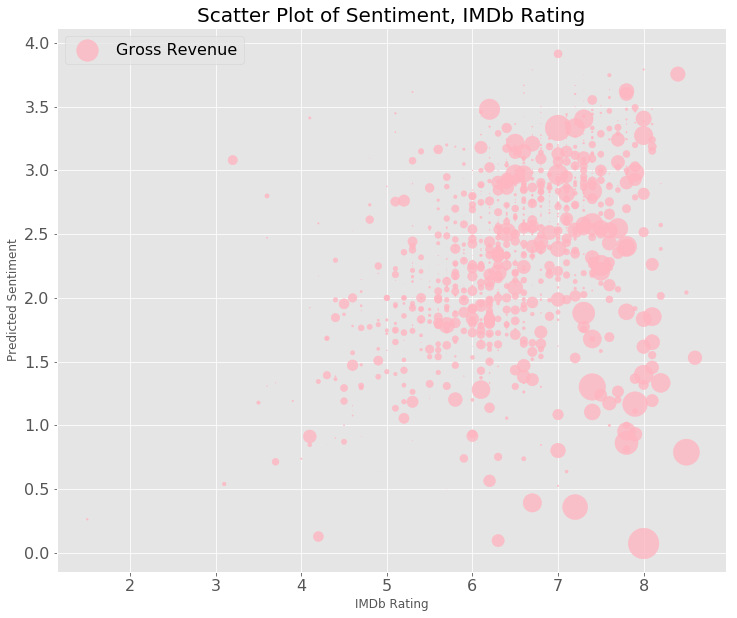

In [97]:
ax = df_movie_fin.plot(kind='scatter',
                       color = 'lightpink',
                       figsize = (12, 10),
                       alpha = 0.8,
                       x='rate', y='predicted_sentiment',
                       fontsize = 16,
                       s=df_movie_fin.Gross)
ax.set_title('Scatter Plot of Sentiment, IMDb Rating', fontsize = 20)
ax.set_ylabel('Predicted Sentiment')
ax.set_xlabel('IMDb Rating')
ax.legend(['Gross Revenue'], loc =2, fontsize = 16)

In [99]:
df_movie_fin.to_csv('general_film.csv')

### Predicting Sentiment Monitor

In [105]:
# load the json data for processing
with open('../Scraping/beast_review.json', 'r') as fp:
    beast_review = json.load(fp)


In [108]:
df_ind_review = pd.DataFrame(beast_review).T

df_ind_review = df_ind_review[df_ind_review['content'] != '']

# date tiem transfer
df_ind_review['date'] = pd.to_datetime(df_ind_review['date'])

# trim rating into integer
df_ind_review['rating'] = df_ind_review['rating'].apply(lambda x : int(x.split('/')[0]))
df_ind_review['rating'] = (df_ind_review['rating'] - 1) //2

# appende the sentiment
df_ind_review['sentiment'] = sentiment_pred_bt

# sort by date
df_ind_review.sort_values('date', inplace= True)

In [183]:
df_ind_group = df_ind_review.groupby('date')
# eliminate the df with too less reviews
df_ind_final = df_ind_group.mean()[5:-2]
df_ind_final['Review Number'] = df_ind_group.count().iloc[5:-2, 0]

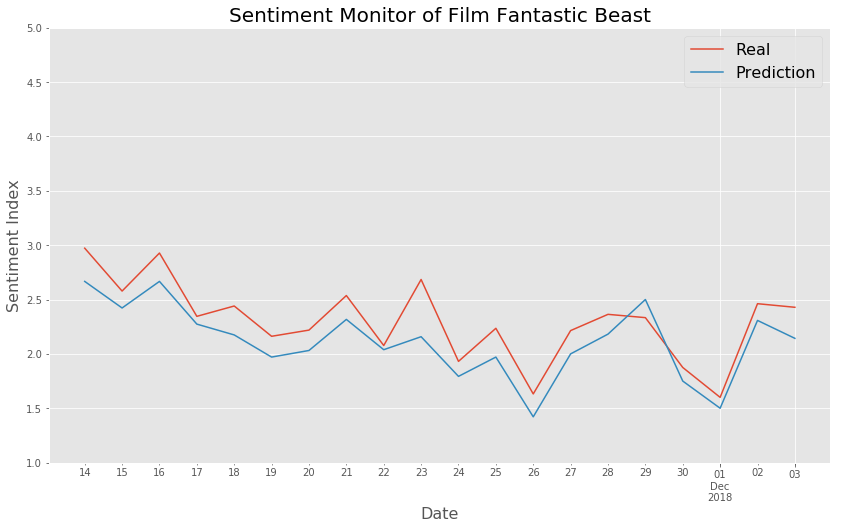

In [208]:
ax = df_ind_final[['rating', 'sentiment']].plot(figsize = (14, 8))
ax.set_title('Sentiment Monitor of Film Fantastic Beast', fontsize = 20)
ax.set_ylim(bottom= 1, top= 5)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Sentiment Index', fontsize = 16)
ax.legend(['Real', 'Prediction'], fontsize = 16)
